In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = list('abcdefghijklmnopqrstuvwxyz')
stoi = { s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = { i+1:s for i, s in enumerate(chars)}
itos[0] = '.'
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
import random
random.seed(42)
random.shuffle(words)

In [156]:
block_size = 8
vocab_size = 27

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)    
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [188]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) # / (fan_in**0.5)
        self.bias = torch.randn((fan_out)) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        # print("linear")
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim) # gain
        self.beta = torch.zeros(dim) # bias
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) 
        
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim = True)
            xvar = x.var(dim, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
#         if self.training == False:
#             print(xmean)
#             print(xvar)
#             print(xhat)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            
        # print("batchnorm")
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        # print("tanh")
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX];
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(x.shape[0], T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        with torch.no_grad():
            layers[-1].weight *= 0.1
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [189]:
torch.manual_seed(42)

In [199]:
n_embd = 8
n_hidden = 64
group_size = 2

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(group_size), Linear(group_size * n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(group_size), Linear(group_size * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(group_size), Linear(group_size * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

19763


In [200]:
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0, 20,  1],
        [ 0,  0,  0,  1, 11, 19,  8,  1],
        [ 0,  0,  3,  1, 12, 12,  1, 12],
        [ 0,  0,  0,  0,  0,  0, 18,  1]])
Embedding : (4, 8, 8)
FlattenConsecutive : (4, 4, 16)
Linear : (4, 4, 64)
BatchNorm1d : (4, 4, 64)
Tanh : (4, 4, 64)
FlattenConsecutive : (4, 2, 128)
Linear : (4, 2, 64)
BatchNorm1d : (4, 2, 64)
Tanh : (4, 2, 64)
FlattenConsecutive : (4, 128)
Linear : (4, 64)
BatchNorm1d : (4, 64)
Tanh : (4, 64)
Linear : (4, 27)


In [201]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim = True)
print(emean.shape)
evar = e.var((0, 1), keepdim = True)
print(evar.shape)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
print(ehat.shape)

torch.Size([1, 1, 68])
torch.Size([1, 1, 68])
torch.Size([32, 4, 68])


In [202]:
# (0 1) (2 3) (4 5) (6 7)
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [203]:
e = torch.randn(4, 8, 10)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
view = e.view(4, 4, 20)
(explicit == view).all()

tensor(True)

In [204]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    x = model(Xb.clone())
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # parameter update
    lr = 1.0 if k < (max_steps / 2) else 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    lossi.append(loss.log10().item())
    if (k % (max_steps / 10)) == 0 or k == max_steps-1:
        print(f'{k:7d}/{max_steps:7d}: {loss.item():.4f}')

      0/ 200000: 4.1670
  20000/ 200000: 2.5667
  40000/ 200000: 2.1539
  60000/ 200000: 2.2312
  80000/ 200000: 2.2710
 100000/ 200000: 2.3774
 120000/ 200000: 1.9642
 140000/ 200000: 2.0548
 160000/ 200000: 1.9480
 180000/ 200000: 1.9863
 199999/ 200000: 2.2047


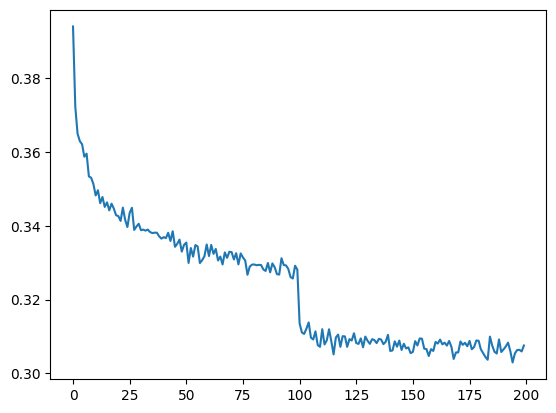

In [195]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [196]:
for layer in model.layers:
    layer.training = False

In [197]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('dev')
split_loss('test')

dev 4.488942623138428
test 4.4939284324646


In [198]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

ryjupnjrjoboucubunbuobopquopyclgo.
ooooorzujpuocrxtsekosokocuzuzyuopseptnozciaocvgjolibkyflbgxfohookpzguuwuoooe.
cuoryjchojoxzcquorzuoioyabofgtambbjen.
oboryooziuouepuodaprnauurzjupfucuu.
owoxnoovrgvfruunucsnuirxipsb.
ouroooccpooruorbjxpesry.
oovojb.
oouuuooojuusscpzhrgktoutxroocoiejovurowouuoebcooikiwofjropxguujrqfwkoszosobfucupr.
ocogjuoogvvyxppyuoqcuojvuistypooukozmgodosqjupqzqroboqt.
aqriocjylbwyfbkqmforoocsoobxuoykgoovpqoxr.
orrtjqgxpclcuoxvupqegvruioupvrrsoubuscusu.
joosjcboujzqcuoq.
jsuorwuoyuupopvyhzogowouszzacrywpitoyosob.
waobogooxziqpubfupobopt.
ryzuqvbpuhugoooswxrof.
jovorouilooe.
yyopcwwtjuptpxsoovuuuqoqfqsubfjcnouovwofggboootzrooouzzqjyoccc.
oojrnoqruqpuusgiccoukgso.
xyrxobpjesoorxouqcopcjieqriuiuuup.
suokzoyzrqxuufb.
